МФТИ: Data Mining in Action (осень, 2016)
- Арсений Ашуха, ars.ashuha@gmail.com, https://vk.com/ars.ashuha
- Дмитрий Персиянов, https://vk.com/persiyanov

<h1 align="center">MNIST Autoencoder</h1> 

Мы хотим сжимать большие вектора (ч/б картинку размером 28x28 можно вытянуть в вектор длины 784) в маленькие так, чтобы уметь хорошо восстанавливать большие вектора. Одна из самых простых моделей -- полносвязный автоэнкодер. Мы применяем к вектору линейные преобразования (умножаем на матрицу) и поэлементные нелинейные. 

![](img/autoencoder_schema.jpg)

Мы хотим увидеть от Вас полносвязынй многослойный автоэнкодер сделанный с помощью библиотеки Лазанья, который будет выглядеть вот-так. 

![](img/fcautoenc.png)

Не бойтесь, это сделать проще, чем выглядит =)

----
 - Если Вы не пользуетесь Linux или macOS, скорее всего Вы столкнетесь с трудностями при установке некоторых библиотек
 - Anaconda Python - самый безболезненный способ поставить почти все и сразу https://www.continuum.io/downloads 
 - Мы будем использовать python 2.7
 
----

**Не пугайтесь, если Вы не понимаете почти ничего. Вы должны немного поправить выданный код.**

### Подключим библиотеки

In [1]:
import theano
import lasagne
import numpy as np
from theano import tensor as T
from utils import load_mnist, iterate_minibatches
%pylab inline

# Если у вас ничего не работает, установите пакеты
# sudo pip install numpy scipy pylab theano lasagne 

/home/re9ulus/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Populating the interactive namespace from numpy and matplotlib


### Загрузим датасет

MNIST - датасет рукописных циферок, данные реальные. Прикладное применение: автоматическая проверка письменных работ.

Прежде чем запускать следующие ячейки, скачайте датасет. Для этого используйте скрипт, который находится в директории с заданием.

```bash
$ ./get_data.sh
```

In [7]:
!./get_data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0   503k      0  0:00:19  0:00:19 --:--:-- 1266k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  63993      0 --:--:-- --:--:-- --:--:-- 64755


In [2]:
import os
import gzip
import numpy as np
from scipy import io
import _pickle as pickle # cPickle is removed from Py3, use _pickle instead

X_train, y_train, shape = load_mnist()

In [3]:
print('Размер трейна картинки x число каналов x высота x ширина', X_train.shape) 

Размер трейна картинки x число каналов x высота x ширина (60000, 1, 28, 28)


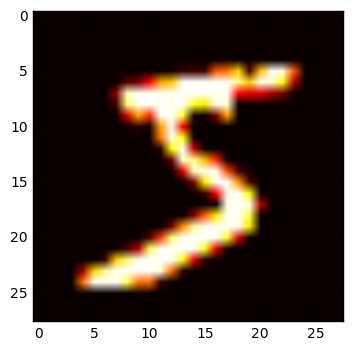

In [4]:
# Нарисуем картинку
pylab.imshow(X_train[0, 0], cmap=pylab.cm.hot)

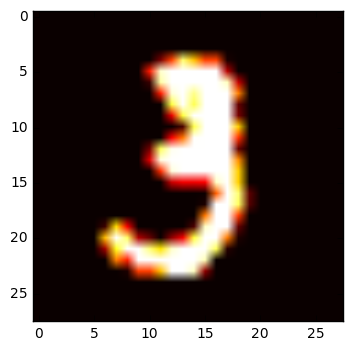

In [11]:
# Нарисуем еще одну
pylab.imshow(X_train[10, 0], cmap=pylab.cm.hot)

### Соберем нейросеть 

Мы хотим сделать нейросеть, которая будет принимать картинку (вектор 28 x 28) и сжимать ее в вектор длины 10 (к примеру). Нашим основным инструментом будет ```lasagne.layers.DenseLayer```. 

In [29]:
# Создадим теано переменные для объектов и ответов
input_x, target_x = T.tensor4("Input value",  dtype='float32'), T.tensor4("Target value", dtype='float32')

In [30]:
# Тут вам нужно собрать автоэнкодер, за вас написаны первый и последний слой,
# Нужно приделать к нему один или несколько средних

net = lasagne.layers.InputLayer((None, 1, 28, 28), input_x, name='Input') # Входной слой
# ...
# mid = <Средний слой>
mid = lasagne.layers.DenseLayer(net, 10*10)
# ...
net = lasagne.layers.DenseLayer(mid, 28*28) # Последний слой
net = lasagne.layers.ReshapeLayer(net, [[0], 1, 28, 28])

In [31]:
# Получим предсказания от сети и определим функцию хорошести предсказания, как l2 норму
predict_train = lasagne.layers.get_output(net)
loss_train = lasagne.objectives.squared_error(predict_train, target_x).mean()

In [32]:
# Получим градиенты для обучения
weights = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss_train, weights, learning_rate=1e-4)

In [33]:
# Скомпилируем теано граф
train_func = theano.function([input_x, target_x], [loss_train], updates=updates, allow_input_downcast=True)
predi_func = theano.function([input_x], [predict_train], allow_input_downcast=True)
mid_func = theano.function([input_x], [lasagne.layers.get_output(mid)], allow_input_downcast=True)

### Обучим автоэнкодер

In [34]:
for i in range(10):
    loss, num_pass = 0, 0
    for (inputs, targets) in iterate_minibatches(X_train, X_train, 100, shuffle=True):
        loss += train_func(inputs, targets)[0]
        num_pass += 1  
    print('epoch:', i, 'loss = ', loss/num_pass, 'ok' if loss/num_pass < 0.05 else 'need to add more layers')

epoch: 0 loss =  0.0470884263369 ok
epoch: 1 loss =  0.0200169915427 ok
epoch: 2 loss =  0.0142654531019 ok
epoch: 3 loss =  0.0117722549592 ok
epoch: 4 loss =  0.0103862994857 ok
epoch: 5 loss =  0.00948992577198 ok
epoch: 6 loss =  0.00881753533685 ok
epoch: 7 loss =  0.00832870777462 ok
epoch: 8 loss =  0.00796110682572 ok
epoch: 9 loss =  0.00767200352732 ok


### Смотрим как мы научились востанавливать цифры

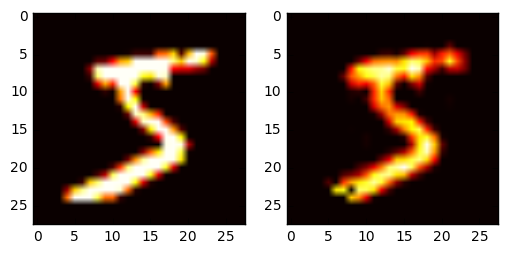

In [35]:
pylab.subplot(121)
pylab.imshow(X_train[0, 0], cmap=pylab.cm.hot)
pylab.subplot(122)
pylab.imshow(predi_func(X_train[0, 0].reshape(1, 1, 28, 28))[0][0][0], cmap=pylab.cm.hot)

### Проецируем в 2d

Давайте теперь спроецируем ответы автоэнкодера в 2d c помощью метода tsne

In [12]:
from sklearn.manifold import TSNE

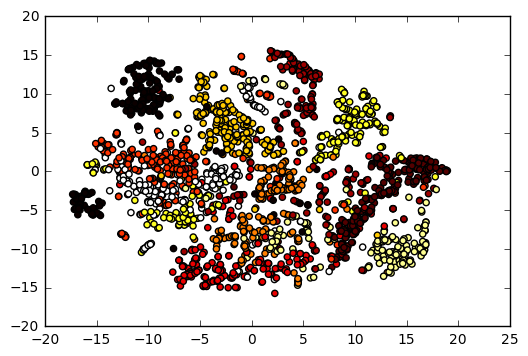

In [13]:
X_mid = mid_func(X_train)[0]
X_tsne = TSNE(n_components=2, n_iter=200).fit_transform(X_mid[:2000])
pylab.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:2000], cmap=pylab.cm.hot)

### Сдача домашки

А теперь, чтобы сдать задание, вам нужно решить загадку. Мы (преподы) натренировали автоэнкодер, и показываем вам только выходы энкодера, очень хотим, чтобы вы натренировали декодер и прислали нам какие цифры изображены на некоторых картинках.

Раньше у вас была обучающая выборка из пар (Объект=Картинка, Ответ=Картинка), а теперь (Объект=маленький вектор, Ответ=Картинка). 

А теперь нужно заполнить гугл фому https://goo.gl/forms/GwTOpUkD20HEuDZv1.

**Нужно вводить ответы на цифры из теста!**
```python
y = X_test_mid
pylab.imshow(predi_func(y[idx].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)```

In [16]:
X_train_mid, y_train, X_test_mid = np.load('X_train_mid.npy'), X_train, np.load('X_test_mid.npy')

In [17]:
print('train shape: ', X_train_mid.shape)

train shape:  (60000, 20)


In [19]:
# В этой ячейке все тоже самое только нету части сети до mid слоя
# Вам нужно натренировать декодер
# Получить предсказания для теста (X_test_mid) и заслать решение не кегл

# net = lasagne.layers.InputLayer((None, 1, 20, 20), input_x, name='Input') # Входной слой
# mid = lasagne.layers.InputLayer((None, 20), input_x, name='Input')
# net = lasagne.layers.DenseLayer(net, 28*28) # Последний слой
# net = lasagne.layers.ReshapeLayer(net, [[0], 1, 28, 28])

##
input_x, target_x = T.matrix("Input value",  dtype='float32'), T.tensor4("Target value", dtype='float32')
mid = lasagne.layers.InputLayer((None, 20), input_x, name='Input')
net = lasagne.layers.DenseLayer(mid, 28*28) # Последний слой
net = lasagne.layers.ReshapeLayer(net, [[0], 1, 28, 28])

In [20]:
# Получим предсказания от сети и определим функцию хорошести предсказания, как l2 норму
predict_train = lasagne.layers.get_output(net)
loss_train = lasagne.objectives.squared_error(predict_train, target_x).mean()
# Получим градиенты для обучения
weights = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss_train, weights, learning_rate=1e-4)
# Скомпилируем теано граф
train_func = theano.function([input_x, target_x], [loss_train], updates=updates, allow_input_downcast=True)
predi_func = theano.function([input_x], [predict_train], allow_input_downcast=True)
mid_func = theano.function([input_x], [lasagne.layers.get_output(mid)], allow_input_downcast=True)

In [25]:
for i in range(25): # original 5
    loss, num_pass = 0, 0
    for (inputs, targets) in iterate_minibatches(X_train_mid, X_train, 100, shuffle=True):
        loss += train_func(inputs, targets)[0]
        num_pass += 1  
    print('epoch:', i, 'loss = ', loss/num_pass)

epoch: 0 loss =  0.0547178087385
epoch: 1 loss =  0.052153823406
epoch: 2 loss =  0.0502828102035
epoch: 3 loss =  0.0488423369814
epoch: 4 loss =  0.0478129547347
epoch: 5 loss =  0.0471122135981
epoch: 6 loss =  0.0465656791338
epoch: 7 loss =  0.0461788438089
epoch: 8 loss =  0.0458946008224
epoch: 9 loss =  0.0456877017249
epoch: 10 loss =  0.0455359092411
epoch: 11 loss =  0.0454184056146
epoch: 12 loss =  0.0453238949545
epoch: 13 loss =  0.0452250694683
epoch: 14 loss =  0.0451462826717
epoch: 15 loss =  0.0450898996045
epoch: 16 loss =  0.0450468315836
epoch: 17 loss =  0.0450111070145
epoch: 18 loss =  0.0449841635744
epoch: 19 loss =  0.0449592152852
epoch: 20 loss =  0.0448689093225
epoch: 21 loss =  0.0448272281574
epoch: 22 loss =  0.0447916849108
epoch: 23 loss =  0.0447605881759
epoch: 24 loss =  0.0447207162374


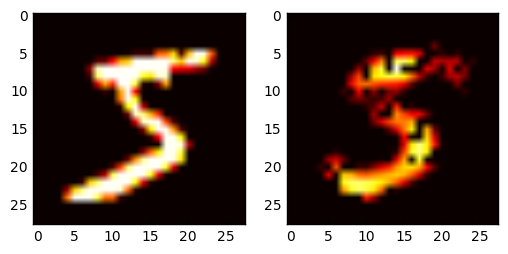

In [26]:
pylab.subplot(121)
pylab.imshow(X_train[0, 0], cmap=pylab.cm.hot)
pylab.subplot(122)
pylab.imshow(predi_func(X_train_mid[0].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)

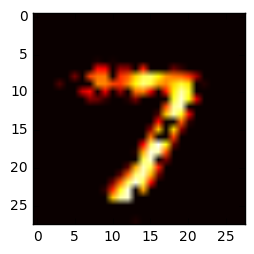

In [27]:
pylab.subplot(122)
pylab.imshow(predi_func(X_test_mid[0].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)